# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, MomentumPortfolio

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#import FinanceDataReader as fdr
import pandas as pd
#import warnings

#warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
path_data = 'data'

## Implement

### class1

In [15]:
import numpy as np

class MomentumPortfolio():
    def __init__(self, df_assets, lookback=12, lag=0, days_in_year=246):
        bm = BacktestManager(df_assets, days_in_year=days_in_year, align_axis=1)
        self.df_assets = bm.df_assets
        self.lookback = lookback 
        self.lag = lag 
        self.selected = None
        
    
    def select(self, date=None, n_assets=5, method='simple'):
        df_assets = self.df_assets
        if date is not None:
            df_assets = df_assets.loc[:date]
        date = df_assets.index.max()
        dt1 = date - pd.DateOffset(days=self.lag)
        dt0 = dt1 - pd.DateOffset(months=self.lookback)
        df_data = df_assets.loc[dt0:dt1]

        if method.lower() == 'k-ratio':
            rank = df_data.pct_change(1).apply(lambda x: calc_kratio(x.dropna())).sort_values(ascending=False)[:n_assets]
        else: # default simple
            rank = bt.ffn.calc_total_return(df_data).sort_values(ascending=False)[:n_assets]

        assets = rank.index
        self.selected = {'date': date.strftime('%Y-%m-%d'),
                         'rank': rank, 'data': df_data[assets]}
        return None

    
    def weigh(self, method='erc'):
        selected = self.selected
        if selected is None:
            return print('ERROR')
        else:
            df_data = selected['data']
            assets = df_data.columns
            
        if method.lower() == 'erc':
            weights = bt.ffn.calc_erc_weights(df_data.pct_change(1).dropna())
        elif method.lower() == 'invvol':
            weights = bt.ffn.calc_inv_vol_weights(df_data.pct_change(1).dropna())
        else: # default equal
            weights = {x:1/len(assets) for x in assets}
            weights = pd.Series(weights)
        self.selected['weights'] = weights
        return weights
        

    def balance(self, holding=None, capital=10000000, commissions=0):
        """
        calc number of each asset with price and weights
        holding: dict of asset-number of holdings
        """
        selected = self.selected
        if selected is None:
            return print('ERROR')
        
        try:
            date = selected['date']
            weights = selected['weights']
            assets = weights.index
        except KeyError as e:
            return print('ERROR')

        df_prc = self.df_assets.loc[date]
        a = capital / (1+commissions/100)
        df_bal = a * pd.Series(weights).mul(1/df_prc.loc[assets]).rename('balance')

        if holding is not None:
            if isinstance(holding, dict):
                holding = pd.Sereis(holding)
            df_bal = (df_bal.sub(holding, fill_value=0).to_frame('transaction')
                            .join(df_bal, how='outer').fillna(0))

        df_bal = df_prc.apply(lambda x: f'{x:,}').to_frame('price').join(df_bal.apply(np.floor).astype(int), how='right')
        return df_bal

    
    def _check_var(self, arg, arg_self):
        return arg_self if arg is None else arg

In [305]:
k200 = MomentumPortfolio(df_k200, 246)

15 assets removed for shorter periods (7.5%)


In [306]:
k200.select('2024-05-01')

In [307]:
k200.weigh()

042700    0.179430
267260    0.209935
022100    0.157920
003230    0.256523
010120    0.196192
Name: erc, dtype: float64

In [308]:
holding = k200.balance()
holding

,price,balance
042700,"135,000",13
267260,"247,000",8
022100,"40,750",38
003230,"295,500",8
010120,"176,600",11


In [309]:
k200.select()
k200.weigh()
k200.balance()

,price,balance
003230,"588,000",3
042700,"160,200",11
267260,"311,000",6
010120,"197,000",9
079550,"198,100",11


In [310]:
k200.balance(holding.balance)

,price,transaction,balance
003230,"588,000",-5,3
010120,"197,000",-2,9
022100,"37,050",-38,0
042700,"160,200",-2,11
079550,"198,100",11,11
267260,"311,000",-2,6


In [296]:
holding.price.apply(lambda x: f'{x}')

042700    135000
267260    247000
022100     40750
003230    295500
010120    176600
Name: price, dtype: object

In [301]:
# Python3 code to demonstrate working of 
# Adding comma between numbers 
# Using str.format() 

# initializing number 
test_num = 1234567

# printing original number 
print("The original number is : " + str(test_num)) 

# Using str.format() 
# Adding comma between numbers 
#res = ('{:,}'.format(test_num)) 
res = '{:,}'.format(test_num) 

# printing result 
#print("The number after inserting commas : " + str(res)) 
print("The number after inserting commas : " + res) 


The original number is : 1234567
The number after inserting commas : 1,234,567


In [300]:
res

'1,234,567'

In [303]:
a = 10000
a = f'{a:,}'
a

'10,000'

### testing

In [75]:
a = {1:10, 2:20, 3:30}
max(a.keys())

3

In [30]:
cols = bm.get_balance(1).index
cols

Momentum: quantity of securities on 2024-06-14 returned


Index(['003230', '010120', '022100', '042700', '267260'], dtype='object', name='Security')

In [31]:
lookback = 12
lag = 5

dt1 = df_k200.index.max() - pd.DateOffset(days=lag)
dt0 = dt1 - pd.DateOffset(months=lookback)
prc = df_k200.loc[dt0:dt1, cols]

bt.ffn.calc_erc_weights(prc.pct_change(1).dropna())

Security
003230    0.232657
010120    0.188485
022100    0.179729
042700    0.191453
267260    0.207677
Name: erc, dtype: float64

In [10]:
import bt

lookback = 12
lag = 5
n_assets = 5

dt1 = df_k200.index.max() - pd.DateOffset(days=lag)
dt0 = dt1 - pd.DateOffset(months=lookback)
prc = df_k200.loc[dt0:dt1]

selected = bt.ffn.calc_total_return(prc).sort_values(ascending=False)[:n_assets]

#bt.ffn.calc_erc_weights(prc.pct_change(1).dropna())
selected


003230    5.445087
042700    4.705298
267260    4.123967
010120    1.905138
079550    1.729529
dtype: float64

In [11]:
from pf_custom import calc_kratio

In [21]:
lookback = 12
lag = 5
n_assets = 5

df = bm.df_assets

dt1 = df.index.max() - pd.DateOffset(days=lag)
dt0 = dt1 - pd.DateOffset(months=lookback)
#prc = df_k200.loc[dt0:dt1]
prc = df.loc[dt0:dt1]
#ret = bt.ffn.to_returns(prc).dropna()

#selected = calc_kratio(ret).sort_values(ascending=False)[:n_assets]
selected = prc.pct_change(1).apply(lambda x: calc_kratio(x.dropna())).sort_values(ascending=False)[:n_assets]

#bt.ffn.calc_erc_weights(prc.pct_change(1).dropna())
selected


175330    96.779872
042700    80.194643
138040    78.913026
001040    72.995139
024110    66.344389
dtype: float64

In [18]:
import numpy as np

#def calc_kratio(ret):
ret_cs = np.log(1 + ret).cumsum() 
X = list(range(len(ret)))
Y = ret_cs

,000080,000100,000120,000150,000210,000240,000270,000660,000670,000720,...,280360,282330,285130,298020,298050,300720,316140,326030,336260,352820
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,32000,69394,168500,52000,75000,14400,64000,126000,540000,37216,...,105500,132000,264211,213000,151000,10600,9510,154500,56300,156420
2021-01-05,33200,69219,177000,52400,75000,14300,63700,130500,566000,39016,...,104500,134500,261209,211500,152500,10550,9610,160500,57000,156915
2021-01-06,34300,67116,172000,51700,75000,14350,62200,131000,565000,38773,...,105500,134000,256872,210000,153500,10450,9580,159500,54500,156915
2021-01-07,35400,65627,174500,53400,75000,14500,63000,134500,573000,39454,...,106500,136500,257206,224000,160000,10800,9840,158500,55700,155430
2021-01-08,34800,67203,173000,53800,75000,15000,68300,138000,573000,39892,...,108000,141000,254870,226500,162000,10750,9910,159500,57100,158895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,21250,80900,95100,217000,59100,15210,129300,236500,339000,32050,...,183400,103300,48800,345000,378000,13400,14690,77500,21150,202500
2024-07-01,20850,83800,95300,208000,58600,15370,128600,235500,338500,33200,...,170500,107200,49200,349500,368000,13420,14400,78900,20600,200500
2024-07-02,20550,77000,92700,204500,57400,15130,123600,232000,336000,32200,...,178500,106400,48200,344000,360000,13400,14480,78400,20000,197200


# KOSPI 200

## Data

In [4]:
file = 'kospi200_prices_240704.csv'
k200 = DataManager(file, path_data)
df_k200 = k200.upload()

In [5]:
#df_k200 = k200.download()

In [6]:
days_in_year = 246

## Backtest

In [6]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = days_in_year
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)


In [7]:
name = 'KOSPI'
ticker = '069500'
df_kospi = bm.util_import_data(ticker, name=name)

In [8]:
bm.benchmark(df_kospi)

RunOnce selected


In [9]:
kwargs_build = dict(
    name = 'Momentum',
    freq = 'M', select = 'Momentum', weigh = 'ERC',
    n_assets=5, lookback=12, lag=12
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KOSPI, Momentum


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]

Returning stats


,KOSPI,Momentum
start,2021-01-03 00:00:00,2021-01-03 00:00:00
end,2024-07-04 00:00:00,2024-07-04 00:00:00
total_return,0.040538,4.914072
cagr,0.011422,0.661896
calmar,0.033355,2.390372
max_drawdown,-0.342432,-0.276901
avg_drawdown,-0.08767,-0.05712
avg_drawdown_days,210.5,17.44186
daily_vol,0.171906,0.381679
daily_sharpe,0.153201,1.548286


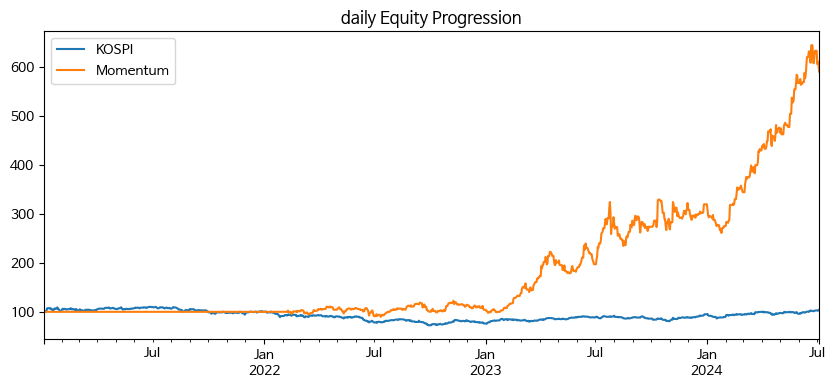

In [10]:
bm.run(figsize=(10,4))

## Balance

In [7]:
k200 = MomentumPortfolio(df_k200, days_in_year)

15 assets removed for shorter periods (7.5%)


In [10]:
k200.select('2024-06-01')
k200.weigh()
h = k200.balance()

In [13]:
k200.select()
k200.weigh()
k200.balance(h.balance)

,price,transaction,balance
001570,"82,800",0,17
002710,"53,500",-3,30
042700,"160,200",0,12
138040,"83,400",-3,32
267260,"311,000",-1,6
